In [1]:
# downloading dataset from https://archive.materialscloud.org/record/2020.110

!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/pozdn/.wget-hsts'. HSTS will be disabled.
--2020-10-08 14:56:30--  https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528
Resolving archive.materialscloud.org (archive.materialscloud.org)... 148.187.96.41
Connecting to archive.materialscloud.org (archive.materialscloud.org)|148.187.96.41|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?response-content-type=application%2Foctet-stream&response-content-disposition=attachment%3B%20filename%3Dmethane.extxyz.gz&Expires=1602161850&Signature=VRtScZtRqtRVf1MFZCKXUrPoBMY%3D&AWSAccessKeyId=ee64314446074ed3ab5f375a522a4893 [following]
--2020-10-08 14:56:30--  https://object.cscs.ch/archive/b6/12/d8e3-58af-4374-96ba-b3551ac5d2f4/data?respons

In [2]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge

In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [3]:
HARTREE_TO_EV = 27.211386245988
train_subset = "0:100000"    #input for ase.io.read command
test_subset = "3050000:3130000"     #input to ase.io.read command
environments_for_fitting = 5000    #number of environments to fit nice transfomers
grid =   [150, 200, 350, 500, 750, 1000, 1500, 2000, 3000,
          5000, 7500, 10000, 15000, 20000,
          30000, 50000, 75000, 100000] #for learning curve

#HYPERS for librascal spherical expansion coefficients
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO'
}

In [4]:
#our model:
def get_transformer():
    return StandardSequence([StandardBlock(ThresholdExpansioner(num_expand = 1000),
                                              CovariantsPurifierBoth(max_take = 100),
                                                  IndividualLambdaPCAsBoth(500),
                                                 None,
                                                 None,
                                                  None),
                            StandardBlock(ThresholdExpansioner(num_expand = 3000),
                                              CovariantsPurifierBoth(max_take = 100),
                                                  IndividualLambdaPCAsBoth(500),
                                                  ThresholdExpansioner(num_expand = 5000, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 100),
                                                 InvariantsPCA(n_components = 1000)),
                             StandardBlock(None,
                                             None,
                                                  None,
                                                  ThresholdExpansioner(num_expand = 5000, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 100),
                                                  InvariantsPCA(n_components = 2000))
                                   ],
                            initial_scaler = InitialScaler(mode = 'signal integral',
                                                           individually = True))

In [5]:
train_structures = ase.io.read('methane.extxyz', 
                         index = train_subset)

test_structures = ase.io.read('methane.extxyz', 
                         index = test_subset)

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_spherical_expansion(train_structures, HYPERS, all_species)



test_coefficients = get_spherical_expansion(test_structures, HYPERS, all_species)

100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


In [6]:
#individual transformers for each atomic specie in dataset
transformers = {}
for key in train_coefficients.keys():
    transformers[key] = get_transformer()

In [7]:
for key in train_coefficients.keys():
    transformers[key].fit(train_coefficients[key][:environments_for_fitting])

/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 1000, desired number of environments is 10000, actual number of environments is 5000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 2000, desired number of environments is 20000, actual number of environments is 5000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 1000, desired number of environments is 10000, actual number of environments is 5000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks

In [8]:
train_features = transform_sequentially(transformers, 
                                        train_structures, HYPERS, all_species)
test_features = transform_sequentially(transformers,
                                        test_structures, HYPERS, all_species)

100%|██████████| 160/160 [1:15:38<00:00, 28.37s/it]


In [9]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV


In [10]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second) ** 2))

def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values)) ** 2))

def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)

def estimate_performance(clf, data_train, data_test, targets_train, targets_test):
    clf.fit(data_train, targets_train)
    return get_relative_performance(clf.predict(data_test), targets_test)

In [11]:
errors = []
for el in tqdm.tqdm(grid):   
    errors.append(estimate_performance(BayesianRidge(), train_features[:el],
                                       test_features, train_energies[:el],
                                       test_energies))

100%|██████████| 18/18 [23:38<00:00, 78.81s/it] 


In [12]:
print(errors)

[0.47623420593438737, 0.4782098525035281, 0.3816814004906994, 0.29738741141043773, 0.18592664862207525, 0.1489530349413237, 0.12130925327586155, 0.10561112125846675, 0.09570007005870015, 0.07457174266188499, 0.062075009983335226, 0.05541106199031505, 0.045319967467454814, 0.040102735401585266, 0.03515140638145148, 0.030058949732912912, 0.027370647149219204, 0.026015802332562624]


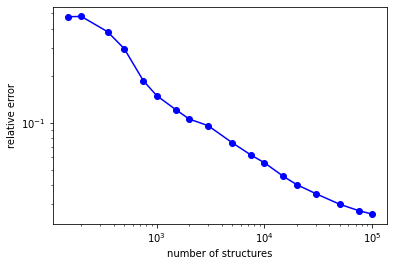

In [13]:
from matplotlib import pyplot as plt
plt.plot(grid, errors, 'bo')
plt.plot(grid, errors, 'b')
plt.xlabel("number of structures")
plt.ylabel("relative error")
plt.xscale('log')
plt.yscale('log')
plt.show()